Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


⏳ Curva de aprendizaje:   0%|          | 0/11 [00:00<?, ?it/s]

🔁 1% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 2% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 3% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 5% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 7% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 10% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 15% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 20% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 30% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 50% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

🔁 70% muestra:   0%|          | 0/3 [00:00<?, ?it/s]

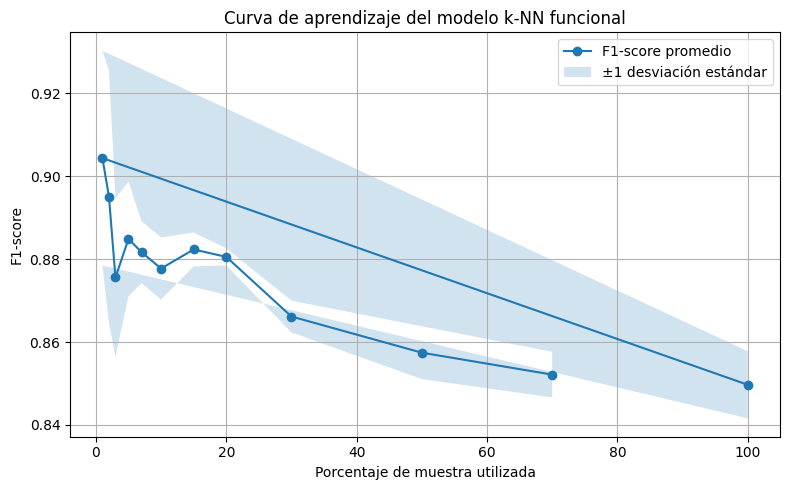

🔁 Bootstrap:   0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-4-48016419612c>:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x="Métrica", y="Valor", palette="pastel")


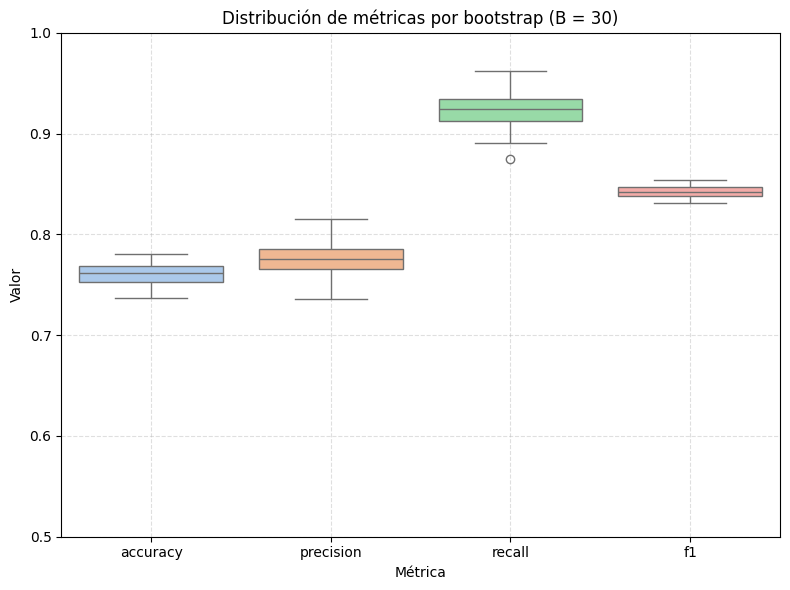

📝 Resumen .tex guardado en: /content/drive/MyDrive/Resultados/12_5_Resumen.tex


In [4]:
# 🚗 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📚 Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, log_loss
)

# 📍 Rutas
ruta_base = "/content/drive/MyDrive/Datos/9_1EspacioF.parquet"
ruta_parametros = "/content/drive/MyDrive/Datos/9_2ParametrosFuncional.pkl"
ruta_resultado_100 = "/content/drive/MyDrive/Resultados/11_1_Resultados_Modelo_Funcional.pkl"
ruta_matriz = "/content/drive/MyDrive/Datos/10_Matriz_Distancias_Funcional.npy"
ruta_nits = "/content/drive/MyDrive/Datos/10_Orden_NITs_Funcional.npy"

# 📄 Cargar base, parámetros y matriz de distancias
df = pd.read_parquet(ruta_base)
with open(ruta_parametros, "rb") as f:
    params = pickle.load(f)
with open(ruta_resultado_100, "rb") as f:
    resumen_p11 = pickle.load(f)["resumen"]
matriz = np.load(ruta_matriz)
nits_matriz = np.load(ruta_nits, allow_pickle=True)

# 🔧 Parámetros del modelo
k_final = params["k"]
lambda_final = params["lambda"]
pesos_finales = params["pesos"]
top3_final = params["top3"]
n_ventana = 5
f1_100 = float(resumen_p11["F1-score"].split(" ±")[0])
std_100 = float(resumen_p11["F1-score"].split(" ±")[1])

# ✅ Asegurar orden
df = df[df["RQ_final"].notna()].copy()
df = df.loc[nits_matriz]
y = df["RQ_final"].values
n = len(df)

# ⚙️ Evaluar modelo funcional reutilizando submatriz
def evaluar_modelo_funcional_con_matriz(matriz_sub, y_sub):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    for train_idx, test_idx in skf.split(matriz_sub, y_sub):
        y_train, y_test = y_sub[train_idx], y_sub[test_idx]
        preds = []
        for i in test_idx:
            distancias = [(matriz_sub[i, j], y_train[list(train_idx).index(j)])
                          for j in train_idx]
            vecinos = sorted(distancias, key=lambda x: x[0])[:k_final]
            proba = np.mean([v[1] for v in vecinos])
            preds.append(round(proba))
        f1_scores.append(f1_score(y_test, preds))
    return np.mean(f1_scores)

# ✅ Crear mapeo de NIT a posición para acceso rápido
mapeo_nits = {nit: i for i, nit in enumerate(nits_matriz)}

# 🔁 Curva de aprendizaje
porcentajes = [0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.30, 0.50, 0.70]
repeticiones = 3
f1_scores = [f1_100]
std_scores = [std_100]
porcentajes_muestra = [100]

for p in tqdm(porcentajes, desc="⏳ Curva de aprendizaje"):
    f1_rep = []
    for r in trange(repeticiones, leave=False, desc=f"🔁 {int(p*100)}% muestra"):
        seed = 1000 + r
        muestra_idx = df.sample(frac=p, random_state=seed).index
        indices = [mapeo_nits[nit] for nit in muestra_idx]  # ⏩ optimizado
        matriz_sub = matriz[np.ix_(indices, indices)]
        y_sub = df.loc[muestra_idx]["RQ_final"].values
        f1 = evaluar_modelo_funcional_con_matriz(matriz_sub, y_sub)
        f1_rep.append(f1)
    f1_scores.append(np.mean(f1_rep))
    std_scores.append(np.std(f1_rep))
    porcentajes_muestra.append(int(p * 100))


# 📈 Gráfico curva
plt.figure(figsize=(8, 5))
plt.plot(porcentajes_muestra, f1_scores, marker='o', label='F1-score promedio')
plt.fill_between(porcentajes_muestra,
                 np.array(f1_scores) - np.array(std_scores),
                 np.array(f1_scores) + np.array(std_scores),
                 alpha=0.2, label='±1 desviación estándar')
plt.xlabel("Porcentaje de muestra utilizada")
plt.ylabel("F1-score")
plt.title("Curva de aprendizaje del modelo k-NN funcional")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Resultados/12_1_Learning_Curve.png")
plt.show()

# 📦 Guardar CSV curva
pd.DataFrame({
    "Porcentaje_muestra": porcentajes_muestra,
    "F1_score_promedio": f1_scores,
    "F1_std": std_scores
}).to_csv("/content/drive/MyDrive/Resultados/12_2_Learning_Curve.csv", index=False)

# 🔁 Bootstrap
B = 30
np.random.seed(2025)
metrics = {m: [] for m in ["accuracy", "precision", "recall", "f1", "auc", "logloss"]}

for b in tqdm(range(B), desc="🔁 Bootstrap"):
    idx = np.random.choice(n, size=n, replace=True)
    test_idx = np.setdiff1d(np.arange(n), idx)
    if len(test_idx) == 0:
        continue
    dists_subset = matriz[np.ix_(test_idx, idx)]
    y_train = y[idx]
    y_test = y[test_idx]
    preds, probs = [], []
    for i, distancias in enumerate(dists_subset):
        vecinos = np.argsort(distancias)[:k_final]
        prob = np.mean(y_train[vecinos])
        pred = round(prob)
        preds.append(pred)
        probs.append(prob)
    metrics["accuracy"].append(accuracy_score(y_test, preds))
    metrics["precision"].append(precision_score(y_test, preds, zero_division=0))
    metrics["recall"].append(recall_score(y_test, preds))
    metrics["f1"].append(f1_score(y_test, preds))
    metrics["auc"].append(roc_auc_score(y_test, probs))
    metrics["logloss"].append(log_loss(y_test, probs))

# 🎯 Boxplot bootstrap
df_metrics = pd.DataFrame(metrics)
df_long = df_metrics[["accuracy", "precision", "recall", "f1"]].melt(
    var_name="Métrica", value_name="Valor")
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_long, x="Métrica", y="Valor", palette="pastel")
plt.title("Distribución de métricas por bootstrap (B = 30)")
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Resultados/12_3_Boxplot_Bootstrap.png")
plt.show()

# 💾 Guardar métricas
with open("/content/drive/MyDrive/Resultados/12_4_Bootstrap_Funcional.pkl", "wb") as f:
    pickle.dump(metrics, f)
# 📝 Guardar resumen en formato .tex para README
ruta_resumen_tex = "/content/drive/MyDrive/Resultados/12_5_Resumen.tex"
with open(ruta_resumen_tex, "w") as f:
    f.write(r"\section*{Paso 12: Análisis de Robustez del Modelo Funcional}" + "\n")
    f.write(r"\begin{itemize}" + "\n")
    f.write(f"  \item Se evaluó la curva de aprendizaje desde 1\% hasta 100\% de la muestra.\n")
    f.write(f"  \item F1-score con el 100\% de los datos: {f1_100:.4f} ± {std_100:.4f}\n")
    f.write("  \item Se aplicó bootstrap con 30 repeticiones para evaluar estabilidad.\n")
    f.write("  \item Se guardaron las siguientes salidas:\n")
    f.write("  \\begin{itemize}\n")
    f.write("    \item \texttt{12\_1\_Learning\_Curve.png}: Gráfico de curva de aprendizaje\n")
    f.write("    \item \texttt{12\_2\_Learning\_Curve.csv}: Tabla de F1-score por tamaño muestral\n")
    f.write("    \item \texttt{12\_3\_Boxplot\_Bootstrap.png}: Distribución de métricas por bootstrap\n")
    f.write("    \item \texttt{12\_4\_Bootstrap\_Funcional.pkl}: Archivo con métricas bootstrap\n")
    f.write("  \\end{itemize}\n")
    f.write(r"\end{itemize}" + "\n")

print(f"📝 Resumen .tex guardado en: {ruta_resumen_tex}")


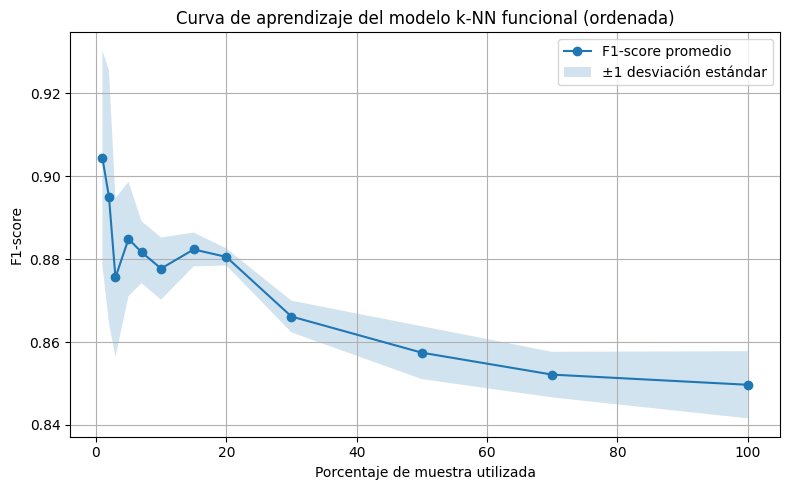

📝 Resumen corregido guardado en: /content/drive/MyDrive/Resultados/12_5_Resumen_CORREGIDO.tex
               mean       std
accuracy   0.760883  0.012007
precision  0.775562  0.017882
recall     0.923010  0.017494
f1         0.842567  0.006628
auc        0.828412  0.011594
logloss    1.083943  0.115703


In [6]:
# 📊 Reordenar resultados para graficar correctamente la curva de aprendizaje
df_plot = pd.DataFrame({
    "Porcentaje": porcentajes_muestra,
    "F1": f1_scores,
    "STD": std_scores
}).sort_values("Porcentaje")

# 📈 Gráfico corregido de la curva de aprendizaje
plt.figure(figsize=(8, 5))
plt.plot(df_plot["Porcentaje"], df_plot["F1"], marker='o', label='F1-score promedio')
plt.fill_between(df_plot["Porcentaje"],
                 df_plot["F1"] - df_plot["STD"],
                 df_plot["F1"] + df_plot["STD"],
                 alpha=0.2, label='±1 desviación estándar')
plt.xlabel("Porcentaje de muestra utilizada")
plt.ylabel("F1-score")
plt.title("Curva de aprendizaje del modelo k-NN funcional (ordenada)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Resultados/12_1_Learning_Curve_CORREGIDA.png")
plt.show()

# 💾 Guardar CSV corregido
df_plot.to_csv("/content/drive/MyDrive/Resultados/12_2_Learning_Curve_CORREGIDA.csv", index=False)

# 📝 Guardar resumen actualizado en formato .tex (indicando corrección de la curva)
ruta_resumen_tex = "/content/drive/MyDrive/Resultados/12_5_Resumen_CORREGIDO.tex"
with open(ruta_resumen_tex, "w") as f:
    f.write(r"\section*{Paso 12: Análisis de Robustez del Modelo Funcional}" + "\n")
    f.write(r"\begin{itemize}" + "\n")
    f.write(f"  \item Se evaluó la curva de aprendizaje desde 1\% hasta 100\% de la muestra.\n")
    f.write(f"  \item F1-score con el 100\% de los datos: {f1_100:.4f} ± {std_100:.4f}\n")
    f.write("  \item Se aplicó bootstrap con 30 repeticiones para evaluar estabilidad.\n")
    f.write("  \item Se corrigió la curva de aprendizaje reordenando los puntos por porcentaje.\n")
    f.write("  \item Se guardaron las siguientes salidas corregidas:\n")
    f.write("  \\begin{itemize}\n")
    f.write("    \item \texttt{12\_1\_Learning\_Curve\_CORREGIDA.png}: Gráfico ordenado\n")
    f.write("    \item \texttt{12\_2\_Learning\_Curve\_CORREGIDA.csv}: Tabla ordenada\n")
    f.write("  \\end{itemize}\n")
    f.write(r"\end{itemize}" + "\n")

print(f"📝 Resumen corregido guardado en: {ruta_resumen_tex}")
import pickle
import pandas as pd

# Cargar métricas del bootstrap
with open("/content/drive/MyDrive/Resultados/12_4_Bootstrap_Funcional.pkl", "rb") as f:
    metrics = pickle.load(f)

df_metrics = pd.DataFrame(metrics)
print(df_metrics.describe().T[["mean", "std"]])
